<a href="https://colab.research.google.com/github/fellowship/platform-demos3/blob/master/InteriorDesignClassification/Multi_Label_Interior_Design_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries and Dataset

In [0]:
# Notebook magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#mount google drive in case we need to store data or transfer files
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# copy the csv file for labels and the dataset folder
import os
os.mkdir('data/')
!cp "drive/My Drive/fellowship/final_data.csv" "data/data.csv"
!cp "drive/My Drive/fellowship/interior_resized_data.tar" "data/"

In [0]:
# Untar the tar file
!tar -zxf data/interior_resized_data.tar -C data/

In [0]:
# Remove the tar file
!rm -rf data/*.tar

In [0]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [7]:
from pathlib import Path
path = Path('data')
imagepath = Path('data/train_images2')
dataset = get_image_files(imagepath)
print(len(dataset))

20097


In [8]:
df = pd.read_csv(path/'data.csv')
df.head()

,images,class
0,img0.jpg,"Classic,Traditional"
1,img1.jpg,"Modern,Glam,Bohemian"
2,img2.jpg,"Modern,Glam,Bohemian"
3,img3.jpg,"Transitional,Farmhouse"
4,img4.jpg,Transitional


## Data Block API and Transfer Learning

In [0]:
tfms = get_transforms(max_warp=0., max_rotate=0)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'data.csv', folder='train_images2')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=','))

In [0]:
data = (src.transform(tfms)
        .databunch(bs=64).normalize(imagenet_stats))

In [12]:
data.classes

['Bohemian',
 'Classic',
 'Coastal',
 'Eclectic',
 'Farmhouse',
 'Glam',
 'Global',
 'Industrial',
 'Midcentury',
 'Minimal',
 'Modern',
 'Preppy',
 'Rustic',
 'Scandinavian',
 'Traditional',
 'Transitional']

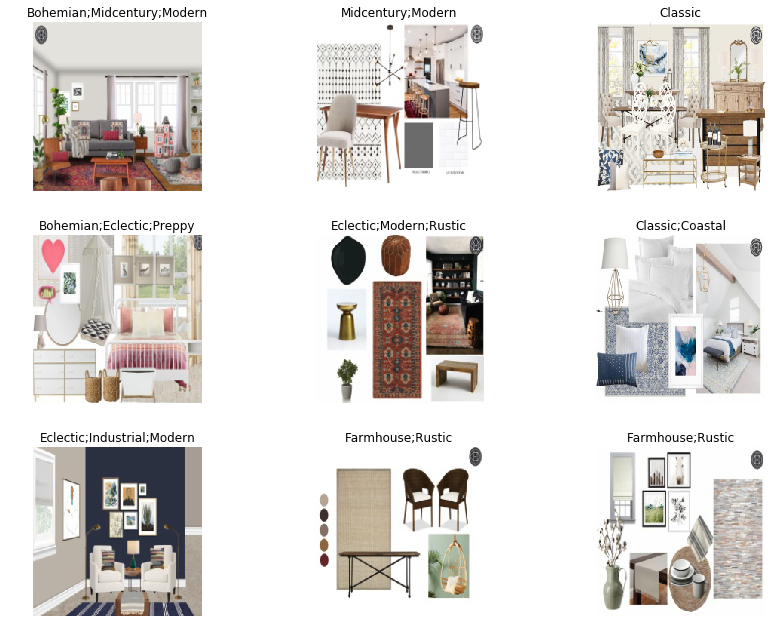

In [13]:
data.show_batch(rows=3, figsize=(12,9))

In [14]:
#acc_02 = partial(accuracy_thresh, thresh=0.4)
#f_score = partial(fbeta, thresh=0.1)
learn = cnn_learner(data, models.resnet50, metrics=[accuracy_thresh, fbeta]) #default values gives better

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:06<00:00, 16307264.06it/s]


## Model Training Resnet 50

### Stage 1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


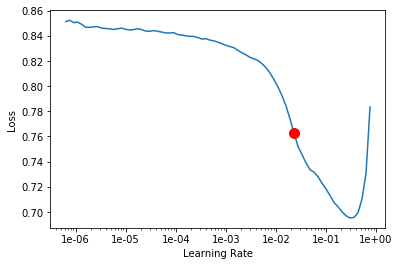

In [15]:
# Freeze the model and plot the Loss- Lr curve
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.333959,0.305049,0.877939,0.514824,02:18
1,0.308243,0.302984,0.877939,0.537572,02:17
2,0.309534,0.321140,0.874596,0.472421,02:16
3,0.308859,0.334780,0.870708,0.436480,02:15
4,0.314891,0.318582,0.875373,0.494004,02:15
5,0.321343,0.340314,0.873009,0.422840,02:14
6,0.320540,0.366014,0.867085,0.450584,02:13
7,0.317512,0.419698,0.863181,0.402691,02:12
8,0.319199,0.359698,0.872123,0.516585,02:12
9,0.315513,0.421809,0.871672,0.477059,02:12


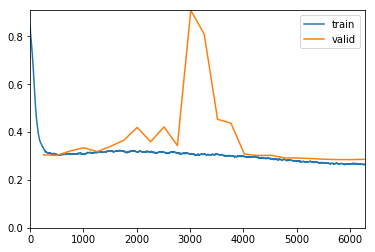

Better model found at epoch 0 with accuracy_thresh value: 0.8779391646385193.
Better model found at epoch 14 with accuracy_thresh value: 0.8790743947029114.
Better model found at epoch 15 with accuracy_thresh value: 0.879649817943573.
Better model found at epoch 16 with accuracy_thresh value: 0.8800074458122253.
Better model found at epoch 18 with accuracy_thresh value: 0.8818269371986389.
Better model found at epoch 19 with accuracy_thresh value: 0.88311767578125.
Better model found at epoch 20 with accuracy_thresh value: 0.8837242126464844.
Better model found at epoch 21 with accuracy_thresh value: 0.8847194314002991.
Better model found at epoch 22 with accuracy_thresh value: 0.885108232498169.
Better model found at epoch 24 with accuracy_thresh value: 0.8852170705795288.


In [16]:
# Training the model for 25 epochs
learn.fit_one_cycle(25, max_lr=2.29e-02, callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy_thresh', name='Stage1-1')])

In [0]:
!cp 'data/models/Stage1-1.pth' 'drive/My Drive/fellowship/'

### Stage 1 Finetuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06


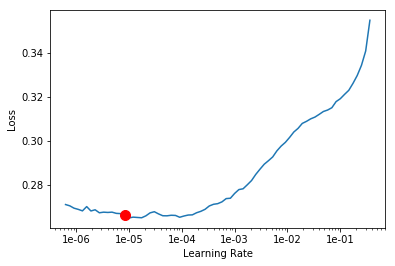

In [19]:
learn = learn.load('Stage1-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.265815,0.284766,0.885139,0.568756,02:56
1,0.266871,0.285477,0.885310,0.571451,02:56
2,0.264192,0.285885,0.885295,0.573893,02:56
3,0.262199,0.290178,0.884642,0.559202,02:56
4,0.263778,0.288189,0.886243,0.572267,02:56
5,0.260341,0.286829,0.886461,0.574242,02:56
6,0.258782,0.282178,0.886959,0.571665,02:56
7,0.256362,0.299530,0.883646,0.553501,02:57
8,0.250559,0.279746,0.887907,0.583404,02:56
9,0.246965,0.284684,0.887799,0.575051,02:56


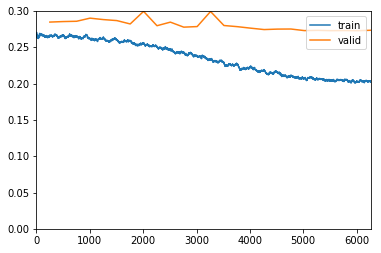

Better model found at epoch 0 with accuracy_thresh value: 0.8851393461227417.
Better model found at epoch 1 with accuracy_thresh value: 0.8853104114532471.
Better model found at epoch 4 with accuracy_thresh value: 0.886243462562561.
Better model found at epoch 5 with accuracy_thresh value: 0.8864611983299255.
Better model found at epoch 6 with accuracy_thresh value: 0.8869588375091553.
Better model found at epoch 8 with accuracy_thresh value: 0.8879074454307556.
Better model found at epoch 10 with accuracy_thresh value: 0.8889182806015015.
Better model found at epoch 11 with accuracy_thresh value: 0.8890582323074341.
Better model found at epoch 14 with accuracy_thresh value: 0.8897113800048828.
Better model found at epoch 15 with accuracy_thresh value: 0.8910021185874939.
Better model found at epoch 16 with accuracy_thresh value: 0.8917641043663025.
Better model found at epoch 19 with accuracy_thresh value: 0.8920440673828125.
Better model found at epoch 20 with accuracy_thresh value: 

In [20]:
# Training the model for 25 epochs
learn.fit_one_cycle(25, max_lr=slice(1e-05,1e-04), callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy_thresh', name='Stage1-2')])

In [0]:
!cp 'data/models/Stage1-2.pth' 'drive/My Drive/fellowship/'

### Further Finetuning

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.202120,0.272825,0.892822,0.593836,02:57
1,0.203696,0.272936,0.892946,0.592684,02:56
2,0.203810,0.272937,0.892308,0.589926,02:56
3,0.203874,0.273256,0.892604,0.593049,02:56
4,0.201276,0.274289,0.892651,0.590759,02:56
5,0.205141,0.273280,0.892775,0.592809,02:56
6,0.202156,0.273960,0.892402,0.591601,02:56
7,0.200970,0.273816,0.892790,0.591872,02:56
8,0.201922,0.273873,0.892588,0.593260,02:57
9,0.201667,0.274753,0.892573,0.587737,02:57


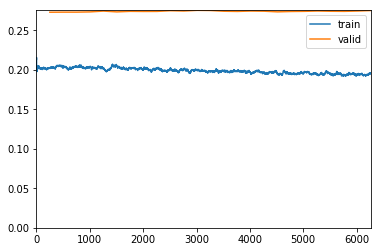

Better model found at epoch 0 with accuracy_thresh value: 0.8928216099739075.
Better model found at epoch 1 with accuracy_thresh value: 0.8929460048675537.
Better model found at epoch 11 with accuracy_thresh value: 0.8930082321166992.
Better model found at epoch 15 with accuracy_thresh value: 0.8931015133857727.
Better model found at epoch 21 with accuracy_thresh value: 0.8931792974472046.
Better model found at epoch 22 with accuracy_thresh value: 0.8933192491531372.


In [32]:
# Training the model for 25 epochs
learn = learn.load('Stage1-2')
learn.unfreeze()
learn.fit_one_cycle(25, max_lr=slice(1e-06,1e-05), callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy_thresh', name='Stage2-1')])

In [0]:
!cp 'data/models/Stage2-1.pth' 'drive/My Drive/fellowship/'

In [0]:
learn.export()
!cp 'data/export.pkl' 'drive/My Drive/fellowship/stage1.pkl'

## Interpolation

In [0]:
learn = learn.load('Stage2-1')

In [36]:
interp = ClassificationInterpretation.from_learner(learn, tta=True)

1566 misclassified samples over 4019 samples in the validation set.


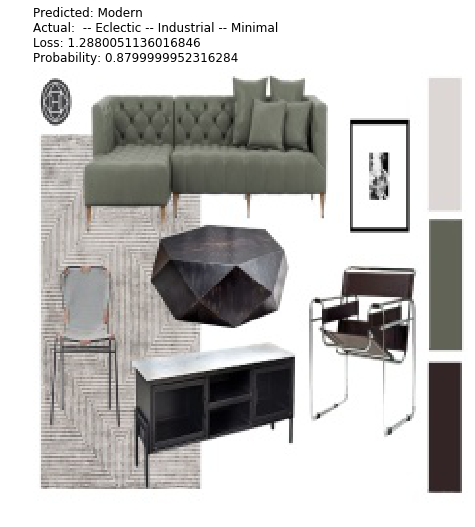

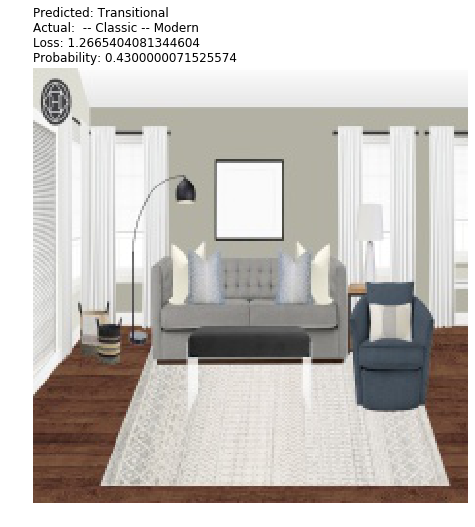

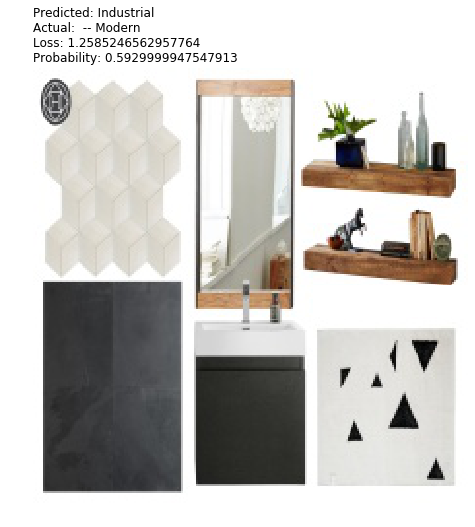

In [38]:
interp.plot_multi_top_losses()

## Predictions

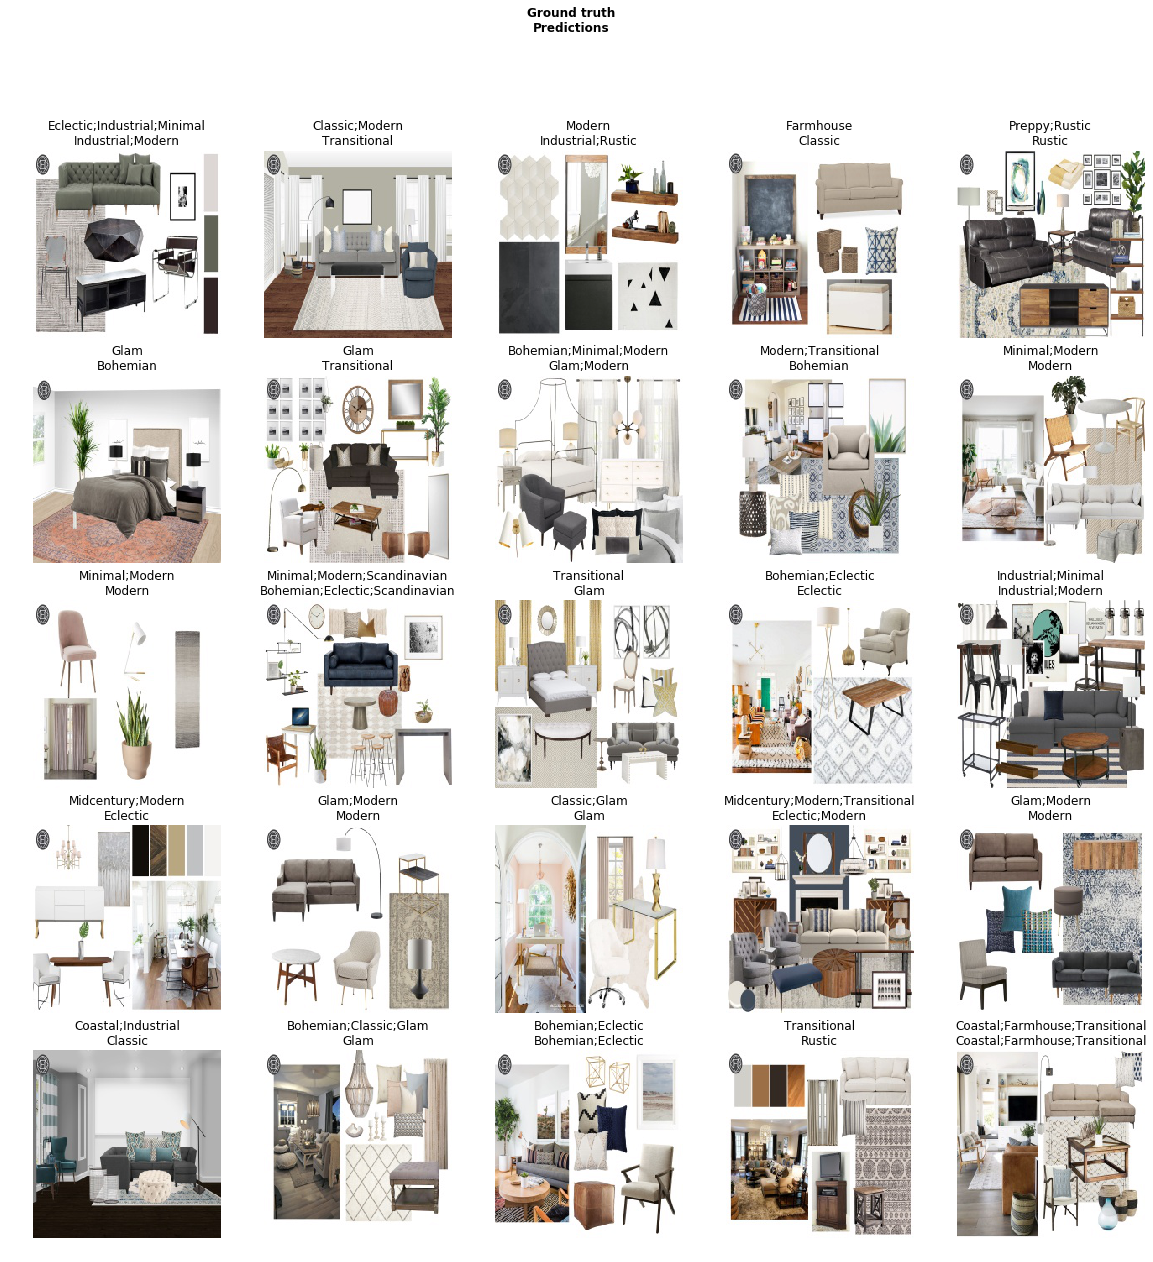

In [47]:
learn.show_results()

In [51]:
loss, acc_05, fscore = learn.validate()
print('Loss:', loss)
print('Accuracy thresh 0.5:', acc_05.numpy())
print('F2-Score:', fscore.numpy())

Loss: 0.2739339
Accuracy thresh 0.5: 0.89331925
F2-Score: 0.5919509


### Prediction on Test images (On Deepdesign.space images)

In [0]:
!pip install wget

In [0]:
import wget
!wget https://raw.githubusercontent.com/YichenQiu/deepdesign.space/master/Image_data/Bohemian/image_Bohemian_interior_design_5.png

True Label: Bohemian
Predicted Labels:  Bohemian;Eclectic


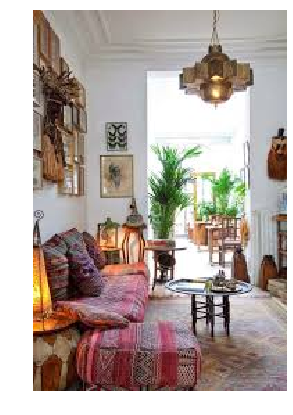

In [65]:
img1 = open_image('image_Bohemian_interior_design_5.png')
prediction = learn.predict(img1, thresh=0.5)
print("True Label: Bohemian")
print("Predicted Labels: ",prediction[0])
img1.show(figsize=(7,7))

In [0]:
!wget https://raw.githubusercontent.com/YichenQiu/deepdesign.space/master/Image_data/Coastal/007d04bd1fcd13a3aedbf343549fe18e.jpg

True Label: Coastal
Predicted Labels:  Modern


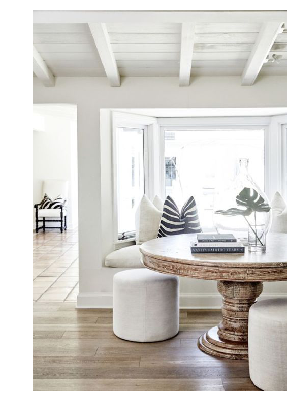

In [108]:
img2 = open_image('007d04bd1fcd13a3aedbf343549fe18e.jpg')
prediction = learn.predict(img2, thresh=0.5)
print("True Label: Coastal")
print("Predicted Labels: ",prediction[0])
img2.show(figsize=(7,7))

In [0]:
!wget https://raw.githubusercontent.com/YichenQiu/deepdesign.space/master/Image_data/Scandinavian/image_scandinavian_interior_design_21.png

True Label: Scandavian
Predicted Labels:  Modern;Scandinavian


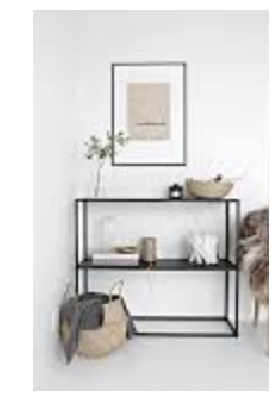

In [105]:
img3 = open_image('image_scandinavian_interior_design_21.png')
prediction = learn.predict(img3, thresh=0.2)
print("True Label: Scandavian")
print("Predicted Labels: ",prediction[0])
img3.show(figsize=(7,7))

In [0]:
!wget https://raw.githubusercontent.com/YichenQiu/deepdesign.space/master/Image_data/Industrial/image_industrial_design_living_room_66.png

True Label: Industrial
Predicted Labels:  Industrial;Modern;Rustic


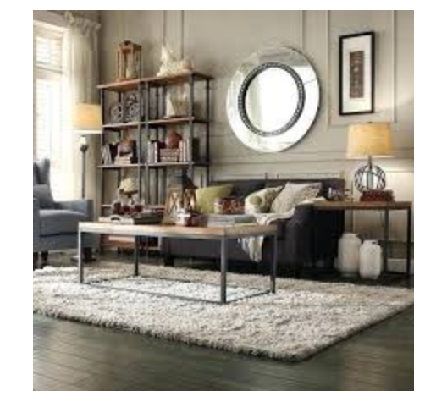

In [113]:
img4 = open_image('image_industrial_design_living_room_66.png')
prediction = learn.predict(img4, thresh=0.4)
print("True Label: Industrial")
print("Predicted Labels: ",prediction[0])
img4.show(figsize=(7,7))